# Week 01 — Projected Birth Rates

This short notebook demonstrates a simple projection workflow using CSO projected births data.

What you'll do in this notebook:

- Locate the CSV file in a nearby `data/` folder.
- Load the data and select the numeric column to plot (usually `VALUE`).
- Clean and prepare a time index for modelling.
- Fit a simple linear model to historical counts and plot the fitted line.
- Project 30 years into the future and save the plot to `generated_charts/`.
- Summarise the fitted model and state a short, plain-language conclusion.

Notes / caveats:
- This notebook shows a simple linear projection for illustration. Real demographic projections use more sophisticated methods and domain knowledge.
- Check units (counts vs rates) before interpreting results.

In [1]:
# Imports and simple settings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from datetime import datetime

plt.style.use('seaborn-v0_8-whitegrid')
np.random.seed(0)

In [2]:
# Find the CSV in nearby data/ folders
FNAME = 'projectedbirths-cso.csv'

def find_csv(start: Path, name: str, levels: int = 4) -> Path | None:
    p = start.resolve()
    for _ in range(levels):
        if (p / 'data' / name).exists():
            return p / 'data' / name
        if (p / 'code' / 'data' / name).exists():
            return p / 'code' / 'data' / name
        p = p.parent
    return None

csv_path = find_csv(Path('.'), FNAME) or find_csv(Path.cwd(), FNAME)
if csv_path is None:
    raise FileNotFoundError(f"Put '{FNAME}' in a nearby data/ folder")

print('Using:', csv_path)

Using: C:\Users\eCron\OneDrive\Documents\ATU_CourseWork\Programming For Data Analytics\programming-for-data-analytics\my-work\data\projectedbirths-cso.csv


In [3]:
# Load data and pick the numeric column to plot
df = pd.read_csv(csv_path)

df['Year'] = pd.to_numeric(df['Year'], errors='coerce')
if 'VALUE' in df.columns:
    y_col = 'VALUE'
elif 'BirthRate' in df.columns:
    y_col = 'BirthRate'
else:
    numcols = df.select_dtypes(include=['number']).columns.tolist()
    y_col = numcols[-1] if numcols else None

if y_col is None:
    raise KeyError('No numeric column to plot')

df[y_col] = pd.to_numeric(df[y_col], errors='coerce')
df_plot = df.dropna(subset=['Year', y_col]).sort_values('Year').reset_index(drop=True)

# Show a short preview
print(df_plot[['Year', y_col]].head())

   Year  VALUE
0  2023  57537
1  2024  55528
2  2025  55292
3  2026  55032
4  2027  54462


Saving to: C:\Users\eCron\OneDrive\Documents\ATU_CourseWork\Programming For Data Analytics\programming-for-data-analytics\my-work\generated_charts
projected_births_2025-10-06_115132.png
projected_births_2025-10-06_115132.png


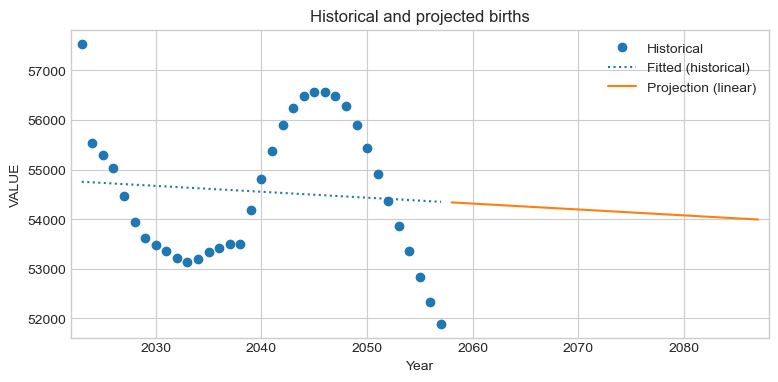

In [4]:
# Define yr0 as the first year in the data
yr0 = df_plot['Year'].min()

# Prepare t and fit the linear model if not already done
t = (df_plot['Year'] - yr0).values.reshape(-1, 1)
model = LinearRegression()
model.fit(t, df_plot[y_col])

# Project 30 years into the future and compute fitted predictions (consistent with script)
future_years = np.arange(df_plot['Year'].max()+1, df_plot['Year'].max()+31)
t_future = (future_years - yr0).reshape(-1,1)
pred_future = model.predict(t_future)

# Build combined years and predictions to draw a continuous fitted line
hist_years = df_plot['Year'].values
last_hist_year = int(hist_years.max())
combined_years = np.concatenate([hist_years, future_years])
combined_years = np.sort(np.unique(combined_years))

t_combined = (combined_years - yr0).reshape(-1,1)
pred_combined = model.predict(t_combined)

# Masks for historic vs projected segments
hist_mask = combined_years <= last_hist_year
proj_mask = combined_years > last_hist_year

# Plot: historical points, fitted (historical) dotted, and projected solid
fig, ax = plt.subplots(figsize=(9,4))
ax.plot(df_plot['Year'], df_plot[y_col], 'o', color='C0', label='Historical')
ax.plot(combined_years[hist_mask], pred_combined[hist_mask], linestyle=':', color='C0', label='Fitted (historical)')
ax.plot(combined_years[proj_mask], pred_combined[proj_mask], linestyle='-', color='C1', label='Projection (linear)')

ax.set_xlabel('Year')
ax.set_ylabel(y_col)
ax.set_title('Historical and projected births')
ax.legend()

# Ensure axes include both historical and projected ranges
x_min = int(min(df_plot['Year'].min(), future_years.min()))
x_max = int(future_years.max())
ax.set_xlim(x_min - 1, x_max + 1)

# compute y-limits from both historical and projected values
y_min = float(min(df_plot[y_col].min(), pred_combined.min()))
y_max = float(max(df_plot[y_col].max(), pred_combined.max()))
# Add a small margin
y_margin = max(1e-6, 0.05 * (y_max - y_min))
ax.set_ylim(y_min - y_margin, y_max + y_margin)

# Save before showing to ensure the file contains the plot
# Make out_dir robust: search parents for 'my-work' first

def resolve_out_dir(csv_path):
    p = Path(csv_path)
    for anc in p.parents:
        if anc.name == 'my-work':
            return anc / 'generated_charts'
    if len(p.parents) >= 2:
        return p.parents[1] / 'generated_charts'
    return Path.cwd() / 'generated_charts'

out_dir = resolve_out_dir(csv_path)
out_dir.mkdir(parents=True, exist_ok=True)
print('Saving to:', out_dir.resolve())

# Timestamped filename to avoid same-day overwrite
ts = datetime.now().strftime('%Y-%m-%d_%H%M%S')
filename = f'projected_births_{ts}.png'
fig.savefig(out_dir / filename, dpi=150, bbox_inches='tight')
print(filename)

plt.show()

### Choose and fit a simple projection model

Below we fit a linear model of the form y(t) = a + b t, where t is years since the start of the data.

- We report the fitted parameters and R² so you can judge how well the line fits the historical data.
- A positive slope (b) means projected counts rise over time; a negative slope means they fall.
- This is an illustrative, not authoritative, projection.

In [5]:
# Show simple summary of findings
coef = model.coef_[0]
intercept = model.intercept_
print(f'Linear model: births = {intercept:.1f} + {coef:.3f} * t')
print('Interpretation: positive coef -> increasing trend; negative -> decreasing.')

# Quick goodness-of-fit
fitted = model.predict(t)
r2 = r2_score(df_plot[y_col], fitted)
print(f'R^2 (fit): {r2:.3f}')

# Short conclusion
if coef < 0:
    print('Conclusion: projected births decrease over time under the linear model.')
else:
    print('Conclusion: projected births increase over time under the linear model.')

Linear model: births = 54754.0 + -11.888 * t
Interpretation: positive coef -> increasing trend; negative -> decreasing.
R^2 (fit): 0.007
Conclusion: projected births decrease over time under the linear model.
